In [1]:
import glob
import warnings
warnings.filterwarnings('ignore')
from osgeo import gdal
from shapely import wkt
from typing import *
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline


from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm

import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import *
from fastai.metrics import  CMScores
from fastai.callbacks import *
import ujson as json
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass


def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj




In [2]:
def to_onehot(indices, num_classes):
        """Convert a tensor of indices of any shape `(N, ...)` to a
        tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
        input's device`.
        """
        
        onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
                             dtype=torch.uint8,
                             device=indices.device)
#         return onehot.scatter_(1, indices.int().unsqueeze(1), 1)
        return onehot.scatter_(1, indices.long().unsqueeze(1), 1)

In [3]:
def colorize_mask_(mask, color_map=None):
    """
    Attaches a color palette to a PIL image. So long as the image is saved as a PNG, it will render visibly using the
    provided color map.
    :param mask: PIL image whose values are only 0 to 4 inclusive
    :param color_map: np.ndarray or list of 3-tuples with 5 rows
    :return:
    """
    color_map = color_map or np.array([(0, 0, 0),  # 0=background
                                       (255, 0, 0),  # no damage (or just 'building' for localization)
                                       (0, 255, 0),  # minor damage
                                       (0, 0, 255),  # major damage
                                       (128, 128, 0),  # destroyed
                                       (0, 128, 128),  # unclassified
                                       ])
    assert color_map.shape == (5, 3)
    mask.putpalette(color_map.astype(np.uint8))
    return None

In [4]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"

train_images_crops = data_dir/"train_crops"
train_mask_crops = data_dir/"mask_crops_single_channel"
test_images_crops = data_dir / "test_crops"
models_path = data_dir / "models"

In [5]:

test_mask_crops = data_dir/"test_mask_crops_damaged_segment"
test_mask_crops.mkdir(exist_ok=True)

In [6]:
unique_img_ids_undamaged= list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() if 'pre' in x.name ]))
unique_img_ids_damaged= list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() if 'post' in x.name ]))

print(len(unique_img_ids_damaged), len(unique_img_ids_undamaged))

np.random.seed(42)
np.random.shuffle(unique_img_ids_undamaged)
train_ids_undamaged = unique_img_ids_undamaged[:int(0.8 * len(unique_img_ids_undamaged))]
valid_ids_undamaged = unique_img_ids_undamaged[int(0.8 * len(unique_img_ids_undamaged)):]

train_ids_damaged = [x.replace('pre', 'post') for x in train_ids_undamaged]
valid_ids_damaged =[x.replace('pre', 'post') for x in valid_ids_undamaged]

print(len(train_ids_damaged), len(valid_ids_damaged))

2283 2283
1826 457


In [7]:
def is_valid_func(fname, valid_ids):
    
    img_id = Path(fname).name.replace('rgb_', '').split('.')[0]

    return img_id in valid_ids

def get_mask_fn(fname):
    return train_mask_crops / fname.name.replace("rgb", "mask")

def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(masks[index]))

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

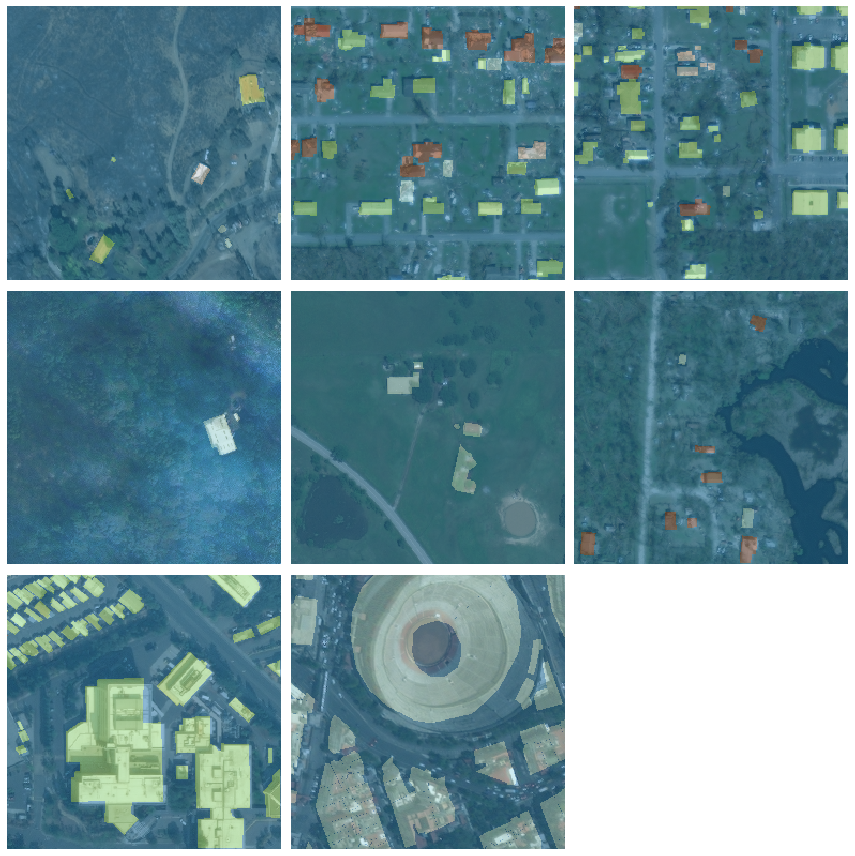

In [9]:
size=256
bs=8
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=False)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

src_post = (SegItemListCustom.from_folder(train_images_crops)
       .filter_by_func(lambda fname: 'post_' in Path(fname).name)
      .split_by_valid_func(partial(is_valid_func, valid_ids=valid_ids_damaged))
       .label_from_func(get_mask_fn, 
            classes=['void', 'no-damage', 'minor-damage', 'major-damage', 'destroyed', 'un-classified']))

data = (src_post.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

data.show_batch(ds_type=DatasetType.Valid)

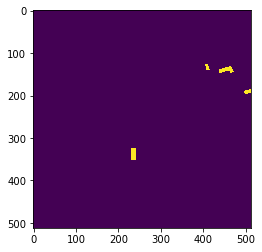

In [12]:
plt.imshow(np.array(PIL.Image.open('/media/wwymak/Storage/xView2/mask_crops_single_channel/mask_midwest-flooding_00000417_post_disaster._4.png')) *255/4)

In [13]:
# from fastai.vision.models.efficientnet import EfficientNetB7

accuracy_pixel=partial(foreground_acc, void_code=0)


wd =1e-2

metrics = [accuracy_pixel, dice, ]
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn.to_fp16();
# learn.lr_find()
# learn.recorder.plot();

In [9]:
class ConfusionMatrix(Callback):
    "Computes the confusion matrix."

    def on_train_begin(self, **kwargs):
        self.n_classes = 0

    def on_epoch_begin(self, **kwargs):
        self.cm = None

    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        print(last_output.shape, last_target.shape)
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.cpu()
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])).sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def on_epoch_end(self, **kwargs):
        self.metric = self.cm

In [50]:
lr=1e-3
# models_path = data_dir / "models"
# learn.model_dir = models_path
# callbacks=[SaveModelCallback(learn, every='improvement', monitor='f1_score', name='xview_buildings_default_unet'),
# #           TerminateOnNaNCallback(),
#            ReduceLROnPlateauCallback(learn, patience=1)
#           ]

learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.239758,0.227311,0.417011,0.468310,04:19
1,0.203329,0.200919,0.370401,0.623567,04:19
2,0.195236,0.188748,0.428852,0.612442,04:19


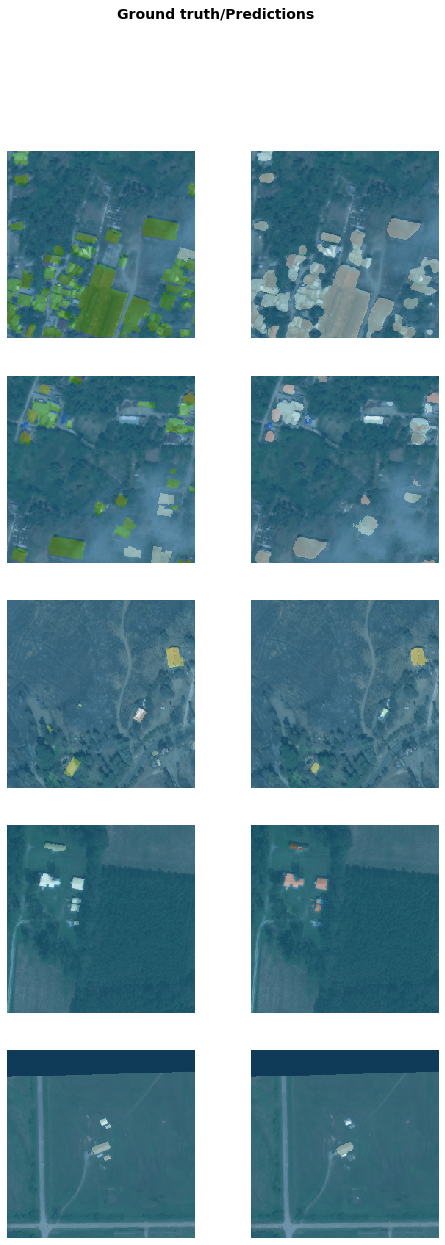

In [51]:
learn.show_results()

In [59]:
b = unet_learner(data, models.resnet18)
b.loss_func

FlattenedLoss of CrossEntropyLoss()

In [9]:
class CombinedLossFocal(nn.Module):

    def __init__(self, frac_focal=0.5, frac_ce=0.5):
        super(CombinedLossFocal, self).__init__()
        self.frac_focal = frac_focal
        self.frac_ce = frac_ce

    def forward(self, inputs, targets, **kwargs):
        #torch.Size([8, 6, 256, 256]) torch.Size([8, 1, 256, 256])
        ce_loss = CrossEntropyFlat(axis=1)(inputs, targets)
        
        focal_loss = FocalLossMultiClass(gamma=2., alpha=0.25)
        
        total_loss = self.frac_ce * ce_loss + \
                self.frac_focal * focal_loss(inputs, targets)
        return total_loss

In [62]:
learn.loss_func = CombinedLossFocal()

In [63]:
lr=1e-5
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.525383,0.505935,0.298562,0.359645,04:25
1,0.415080,0.414772,0.384310,0.539627,04:27
2,0.411867,0.413437,0.411804,0.574683,04:28


In [64]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.408594,0.410420,0.422510,0.590407,04:30
1,0.412643,0.408141,0.415182,0.584260,04:24
2,0.407887,0.408330,0.439480,0.614039,04:25


In [65]:
learn.model_dir = models_path
learn.save('25Dec-segmentation-damage-cls-focalloss')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


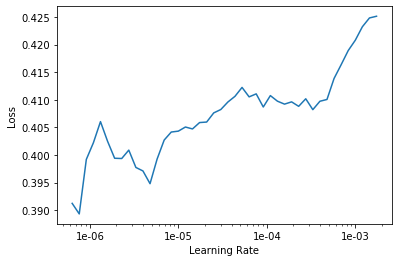

In [66]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [67]:
lr = 1e-6

learn.fit_one_cycle(3, slice(lr/5, lr))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.410454,0.407779,0.419900,0.591155,04:28
1,0.412571,0.407840,0.432389,0.602687,04:30
2,0.416581,0.407681,0.431127,0.605657,04:35


In [68]:
learn.fit_one_cycle(5, slice(lr/5, lr))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.408022,0.407765,0.438527,0.618970,04:36
1,0.414286,0.407156,0.416927,0.594897,04:57
2,0.406586,0.407309,0.429177,0.602116,04:55
3,0.408296,0.407013,0.430210,0.609528,04:34
4,0.410283,0.407372,0.437878,0.617277,04:35


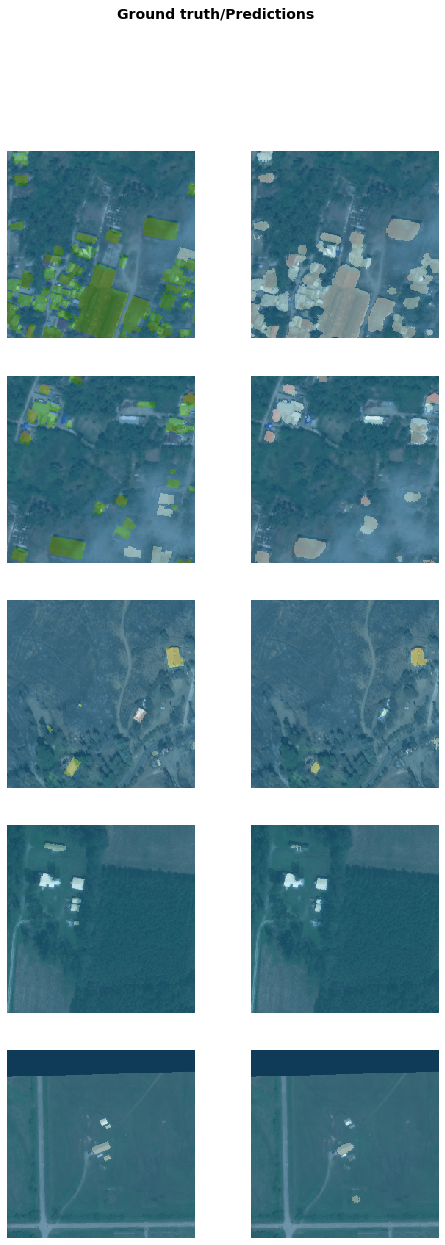

In [69]:
learn.show_results()

In [70]:
learn.save('25Dec-segmentation-damage-cls-focalloss')

In [14]:
# metrics = [accuracy_pixel, dice, ]
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn.model_dir = models_path
learn.load('25Dec-segmentation-damage-cls-focalloss');


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


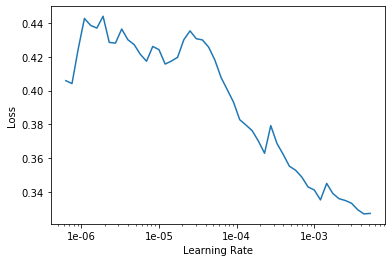

In [15]:
bs=4
size=512

data = (src_post.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn.to_fp32()
learn.data = data
learn.to_fp16()
learn.freeze()
learn.lr_find()
learn.recorder.plot();

In [16]:
lr = 5e-4
learn.fit_one_cycle(3, max_lr=lr)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.221607,0.181351,0.445222,0.602920,14:55
1,0.195968,0.184322,0.409776,0.597839,15:00
2,0.172969,0.164597,0.504234,0.695889,16:50


In [17]:
learn.save('25Dec-segmentation-damage-cls-focalloss')

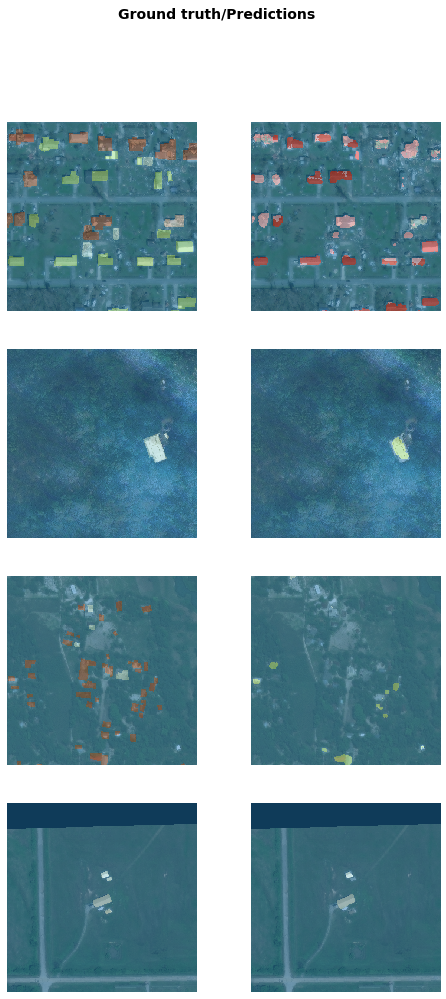

In [18]:
learn.show_results()

In [19]:
learn.fit_one_cycle(3, max_lr=lr/5)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.178225,0.162481,0.525690,0.692040,18:06
1,0.164936,0.161290,0.547922,0.761108,18:10
2,0.176138,0.158867,0.528851,0.740359,15:52


In [20]:
learn.save('25Dec-segmentation-damage-cls-focalloss')

In [21]:
learn.fit_one_cycle(3, max_lr=lr/25)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.174806,0.157666,0.523674,0.742173,16:12
1,0.168362,0.159732,0.521980,0.738962,14:35
2,0.160377,0.158241,0.527313,0.738298,14:54


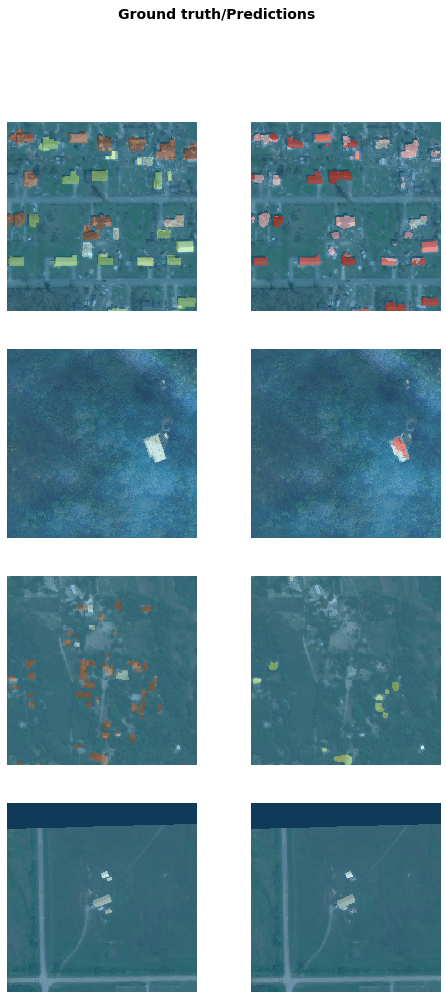

In [22]:
learn.load('25Dec-segmentation-damage-cls-focalloss');
learn.show_results()

hmm, what about adding mae to the loss function?  

(since the further away the predicted label is from the target value th worse it is)

In [10]:
bs=4
size=512
wd=1e-2
accuracy_pixel=partial(foreground_acc, void_code=0)
metrics = [accuracy_pixel, dice, ]
data = (src_post.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .add_test_folder(test_images_crops, tfm_y=False)
        .databunch(bs=bs)
        
        .normalize(imagenet_stats))
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

learn.to_fp16()

learn.model_dir = models_path
learn.load('25Dec-segmentation-damage-cls-focalloss');

In [11]:
data.test_dl.items[:5]

array([PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00072_5.png'),
       PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_post_00775_7.png'),
       PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_post_00227_2.png'),
       PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_post_00889_6.png'),
       PosixPath('/media/wwymak/Storage/xView2/test_crops/rgb_test_pre_00832_2.png')], dtype=object)

In [13]:
test_crops_filenames = [test_mask_crops/x.name.replace('rgb', 'mask') for x in data.test_dl.items]
test_iterator = iter(data.test_dl)
i = 0
print("starting")

for batch in test_iterator:
    print(f"imgs {i}-{i+bs}")
    batch_preds = learn.pred_batch(batch=batch)
    segment_results = torch.max(batch_preds, dim=1).indices.numpy()
    filenames = test_crops_filenames[i: i+ segment_results.shape[0]]
    
    assert segment_results.shape[0] == len(filenames), (filenames, segment_results.shape)
    
    for idx, img_arr in enumerate(segment_results):
        PIL.Image.fromarray(img_arr.astype(np.uint8)).save(filenames[idx], mode='L')
    i += segment_results.shape[0]

starting
imgs 0-4
imgs 4-8
imgs 8-12
imgs 12-16
imgs 16-20
imgs 20-24
imgs 24-28
imgs 28-32
imgs 32-36
imgs 36-40
imgs 40-44
imgs 44-48
imgs 48-52
imgs 52-56
imgs 56-60
imgs 60-64
imgs 64-68
imgs 68-72
imgs 72-76
imgs 76-80
imgs 80-84
imgs 84-88
imgs 88-92
imgs 92-96
imgs 96-100
imgs 100-104
imgs 104-108
imgs 108-112
imgs 112-116
imgs 116-120
imgs 120-124
imgs 124-128
imgs 128-132
imgs 132-136
imgs 136-140
imgs 140-144
imgs 144-148
imgs 148-152
imgs 152-156
imgs 156-160
imgs 160-164
imgs 164-168
imgs 168-172
imgs 172-176
imgs 176-180
imgs 180-184
imgs 184-188
imgs 188-192
imgs 192-196
imgs 196-200
imgs 200-204
imgs 204-208
imgs 208-212
imgs 212-216
imgs 216-220
imgs 220-224
imgs 224-228
imgs 228-232
imgs 232-236
imgs 236-240
imgs 240-244
imgs 244-248
imgs 248-252
imgs 252-256
imgs 256-260
imgs 260-264
imgs 264-268
imgs 268-272
imgs 272-276
imgs 276-280
imgs 280-284
imgs 284-288
imgs 288-292
imgs 292-296
imgs 296-300
imgs 300-304
imgs 304-308
imgs 308-312
imgs 312-316
imgs 316-320
imgs 

imgs 2336-2340
imgs 2340-2344
imgs 2344-2348
imgs 2348-2352
imgs 2352-2356
imgs 2356-2360
imgs 2360-2364
imgs 2364-2368
imgs 2368-2372
imgs 2372-2376
imgs 2376-2380
imgs 2380-2384
imgs 2384-2388
imgs 2388-2392
imgs 2392-2396
imgs 2396-2400
imgs 2400-2404
imgs 2404-2408
imgs 2408-2412
imgs 2412-2416
imgs 2416-2420
imgs 2420-2424
imgs 2424-2428
imgs 2428-2432
imgs 2432-2436
imgs 2436-2440
imgs 2440-2444
imgs 2444-2448
imgs 2448-2452
imgs 2452-2456
imgs 2456-2460
imgs 2460-2464
imgs 2464-2468
imgs 2468-2472
imgs 2472-2476
imgs 2476-2480
imgs 2480-2484
imgs 2484-2488
imgs 2488-2492
imgs 2492-2496
imgs 2496-2500
imgs 2500-2504
imgs 2504-2508
imgs 2508-2512
imgs 2512-2516
imgs 2516-2520
imgs 2520-2524
imgs 2524-2528
imgs 2528-2532
imgs 2532-2536
imgs 2536-2540
imgs 2540-2544
imgs 2544-2548
imgs 2548-2552
imgs 2552-2556
imgs 2556-2560
imgs 2560-2564
imgs 2564-2568
imgs 2568-2572
imgs 2572-2576
imgs 2576-2580
imgs 2580-2584
imgs 2584-2588
imgs 2588-2592
imgs 2592-2596
imgs 2596-2600
imgs 2600-

imgs 4528-4532
imgs 4532-4536
imgs 4536-4540
imgs 4540-4544
imgs 4544-4548
imgs 4548-4552
imgs 4552-4556
imgs 4556-4560
imgs 4560-4564
imgs 4564-4568
imgs 4568-4572
imgs 4572-4576
imgs 4576-4580
imgs 4580-4584
imgs 4584-4588
imgs 4588-4592
imgs 4592-4596
imgs 4596-4600
imgs 4600-4604
imgs 4604-4608
imgs 4608-4612
imgs 4612-4616
imgs 4616-4620
imgs 4620-4624
imgs 4624-4628
imgs 4628-4632
imgs 4632-4636
imgs 4636-4640
imgs 4640-4644
imgs 4644-4648
imgs 4648-4652
imgs 4652-4656
imgs 4656-4660
imgs 4660-4664
imgs 4664-4668
imgs 4668-4672
imgs 4672-4676
imgs 4676-4680
imgs 4680-4684
imgs 4684-4688
imgs 4688-4692
imgs 4692-4696
imgs 4696-4700
imgs 4700-4704
imgs 4704-4708
imgs 4708-4712
imgs 4712-4716
imgs 4716-4720
imgs 4720-4724
imgs 4724-4728
imgs 4728-4732
imgs 4732-4736
imgs 4736-4740
imgs 4740-4744
imgs 4744-4748
imgs 4748-4752
imgs 4752-4756
imgs 4756-4760
imgs 4760-4764
imgs 4764-4768
imgs 4768-4772
imgs 4772-4776
imgs 4776-4780
imgs 4780-4784
imgs 4784-4788
imgs 4788-4792
imgs 4792-

imgs 6720-6724
imgs 6724-6728
imgs 6728-6732
imgs 6732-6736
imgs 6736-6740
imgs 6740-6744
imgs 6744-6748
imgs 6748-6752
imgs 6752-6756
imgs 6756-6760
imgs 6760-6764
imgs 6764-6768
imgs 6768-6772
imgs 6772-6776
imgs 6776-6780
imgs 6780-6784
imgs 6784-6788
imgs 6788-6792
imgs 6792-6796
imgs 6796-6800
imgs 6800-6804
imgs 6804-6808
imgs 6808-6812
imgs 6812-6816
imgs 6816-6820
imgs 6820-6824
imgs 6824-6828
imgs 6828-6832
imgs 6832-6836
imgs 6836-6840
imgs 6840-6844
imgs 6844-6848
imgs 6848-6852
imgs 6852-6856
imgs 6856-6860
imgs 6860-6864
imgs 6864-6868
imgs 6868-6872
imgs 6872-6876
imgs 6876-6880
imgs 6880-6884
imgs 6884-6888
imgs 6888-6892
imgs 6892-6896
imgs 6896-6900
imgs 6900-6904
imgs 6904-6908
imgs 6908-6912
imgs 6912-6916
imgs 6916-6920
imgs 6920-6924
imgs 6924-6928
imgs 6928-6932
imgs 6932-6936
imgs 6936-6940
imgs 6940-6944
imgs 6944-6948
imgs 6948-6952
imgs 6952-6956
imgs 6956-6960
imgs 6960-6964
imgs 6964-6968
imgs 6968-6972
imgs 6972-6976
imgs 6976-6980
imgs 6980-6984
imgs 6984-

imgs 8912-8916
imgs 8916-8920
imgs 8920-8924
imgs 8924-8928
imgs 8928-8932
imgs 8932-8936
imgs 8936-8940
imgs 8940-8944
imgs 8944-8948
imgs 8948-8952
imgs 8952-8956
imgs 8956-8960
imgs 8960-8964
imgs 8964-8968
imgs 8968-8972
imgs 8972-8976
imgs 8976-8980
imgs 8980-8984
imgs 8984-8988
imgs 8988-8992
imgs 8992-8996
imgs 8996-9000
imgs 9000-9004
imgs 9004-9008
imgs 9008-9012
imgs 9012-9016
imgs 9016-9020
imgs 9020-9024
imgs 9024-9028
imgs 9028-9032
imgs 9032-9036
imgs 9036-9040
imgs 9040-9044
imgs 9044-9048
imgs 9048-9052
imgs 9052-9056
imgs 9056-9060
imgs 9060-9064
imgs 9064-9068
imgs 9068-9072
imgs 9072-9076
imgs 9076-9080
imgs 9080-9084
imgs 9084-9088
imgs 9088-9092
imgs 9092-9096
imgs 9096-9100
imgs 9100-9104
imgs 9104-9108
imgs 9108-9112
imgs 9112-9116
imgs 9116-9120
imgs 9120-9124
imgs 9124-9128
imgs 9128-9132
imgs 9132-9136
imgs 9136-9140
imgs 9140-9144
imgs 9144-9148
imgs 9148-9152
imgs 9152-9156
imgs 9156-9160
imgs 9160-9164
imgs 9164-9168
imgs 9168-9172
imgs 9172-9176
imgs 9176-

imgs 10972-10976
imgs 10976-10980
imgs 10980-10984
imgs 10984-10988
imgs 10988-10992
imgs 10992-10996
imgs 10996-11000
imgs 11000-11004
imgs 11004-11008
imgs 11008-11012
imgs 11012-11016
imgs 11016-11020
imgs 11020-11024
imgs 11024-11028
imgs 11028-11032
imgs 11032-11036
imgs 11036-11040
imgs 11040-11044
imgs 11044-11048
imgs 11048-11052
imgs 11052-11056
imgs 11056-11060
imgs 11060-11064
imgs 11064-11068
imgs 11068-11072
imgs 11072-11076
imgs 11076-11080
imgs 11080-11084
imgs 11084-11088
imgs 11088-11092
imgs 11092-11096
imgs 11096-11100
imgs 11100-11104
imgs 11104-11108
imgs 11108-11112
imgs 11112-11116
imgs 11116-11120
imgs 11120-11124
imgs 11124-11128
imgs 11128-11132
imgs 11132-11136
imgs 11136-11140
imgs 11140-11144
imgs 11144-11148
imgs 11148-11152
imgs 11152-11156
imgs 11156-11160
imgs 11160-11164
imgs 11164-11168
imgs 11168-11172
imgs 11172-11176
imgs 11176-11180
imgs 11180-11184
imgs 11184-11188
imgs 11188-11192
imgs 11192-11196
imgs 11196-11200
imgs 11200-11204
imgs 11204-112

imgs 12900-12904
imgs 12904-12908
imgs 12908-12912
imgs 12912-12916
imgs 12916-12920
imgs 12920-12924
imgs 12924-12928
imgs 12928-12932
imgs 12932-12936
imgs 12936-12940
imgs 12940-12944
imgs 12944-12948
imgs 12948-12952
imgs 12952-12956
imgs 12956-12960
imgs 12960-12964
imgs 12964-12968
imgs 12968-12972
imgs 12972-12976
imgs 12976-12980
imgs 12980-12984
imgs 12984-12988
imgs 12988-12992
imgs 12992-12996
imgs 12996-13000
imgs 13000-13004
imgs 13004-13008
imgs 13008-13012
imgs 13012-13016
imgs 13016-13020
imgs 13020-13024
imgs 13024-13028
imgs 13028-13032
imgs 13032-13036
imgs 13036-13040
imgs 13040-13044
imgs 13044-13048
imgs 13048-13052
imgs 13052-13056
imgs 13056-13060
imgs 13060-13064
imgs 13064-13068
imgs 13068-13072
imgs 13072-13076
imgs 13076-13080
imgs 13080-13084
imgs 13084-13088
imgs 13088-13092
imgs 13092-13096
imgs 13096-13100
imgs 13100-13104
imgs 13104-13108
imgs 13108-13112
imgs 13112-13116
imgs 13116-13120
imgs 13120-13124
imgs 13124-13128
imgs 13128-13132
imgs 13132-131

imgs 14828-14832
imgs 14832-14836
imgs 14836-14840
imgs 14840-14844
imgs 14844-14848
imgs 14848-14852
imgs 14852-14856
imgs 14856-14860
imgs 14860-14864
imgs 14864-14868
imgs 14868-14872
imgs 14872-14876
imgs 14876-14880
imgs 14880-14884
imgs 14884-14888
imgs 14888-14892
imgs 14892-14896
imgs 14896-14900
imgs 14900-14904
imgs 14904-14908
imgs 14908-14912
imgs 14912-14916
imgs 14916-14920
imgs 14920-14924
imgs 14924-14928
imgs 14928-14932
imgs 14932-14936
imgs 14936-14940
imgs 14940-14944
imgs 14944-14948
imgs 14948-14952
imgs 14952-14956
imgs 14956-14960
imgs 14960-14964
imgs 14964-14968
imgs 14968-14972
imgs 14972-14976
imgs 14976-14980
imgs 14980-14984
imgs 14984-14988
imgs 14988-14992
imgs 14992-14996
imgs 14996-15000
imgs 15000-15004
imgs 15004-15008
imgs 15008-15012
imgs 15012-15016
imgs 15016-15020
imgs 15020-15024
imgs 15024-15028
imgs 15028-15032
imgs 15032-15036
imgs 15036-15040
imgs 15040-15044
imgs 15044-15048
imgs 15048-15052
imgs 15052-15056
imgs 15056-15060
imgs 15060-150

imgs 16760-16764
imgs 16764-16768
imgs 16768-16772
imgs 16772-16776
imgs 16776-16780
imgs 16780-16784
imgs 16784-16788
imgs 16788-16792
imgs 16792-16796


In [15]:
test_crops_filenames[:10]

[PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_damaged_segment/mask_test_pre_00072_5.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_damaged_segment/mask_test_post_00775_7.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_damaged_segment/mask_test_post_00227_2.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_damaged_segment/mask_test_post_00889_6.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_damaged_segment/mask_test_pre_00832_2.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_damaged_segment/mask_test_pre_00562_6.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_damaged_segment/mask_test_post_00927_0.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_damaged_segment/mask_test_post_00000_0.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_damaged_segment/mask_test_pre_00748_6.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_mask_crops_damaged_segment/mask